<a href="https://colab.research.google.com/github/Nightmare261/Machine-Learning/blob/main/Spam_SMS_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
cd/content/drive/MyDrive/Dataset


/content/drive/MyDrive/Dataset


In [16]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/spam.csv",encoding='latin-1')


In [17]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [49]:
df.shape

(5572, 3)

In [18]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


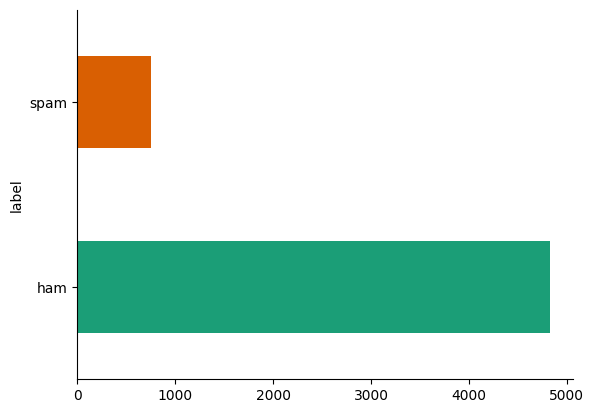

In [20]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

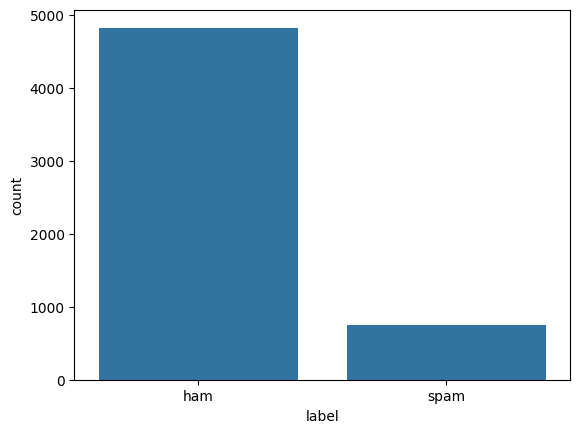

In [19]:

sns.countplot(x=df['label'])
plt.show()

In [21]:

# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

15


In [22]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [25]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
	new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

In [26]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [39]:
y_pred =baseline_model.predict(X_test_vec)
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115

0.9623318385650225


In [45]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test,y_pred)

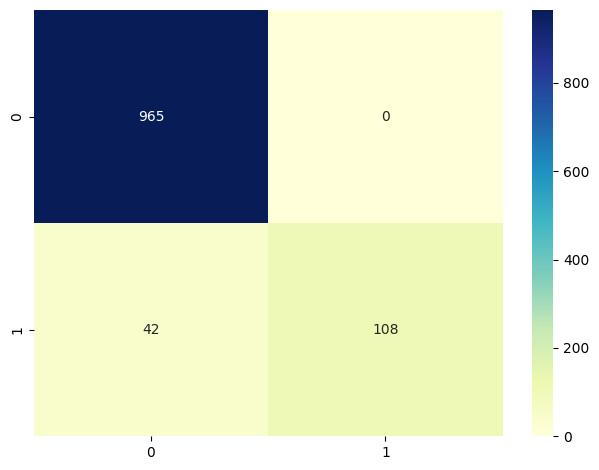

In [48]:
class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu", fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()


In [50]:

from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [51]:
sample_sentence = 'This is a message'
text_vec([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 41,  10,   5, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [52]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [53]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])

In [54]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [58]:
history_1 = model_1.fit(X_train, y_train, epochs=5, validation_data=(X_test,y_test), validation_steps=int(0.2*len (X_test)))

Epoch 1/5
140/140 [==============================] - 14s 65ms/step - loss: 0.6047 - accuracy: 0.9082 - val_loss: 0.5771 - val_accuracy: 0.9704
Epoch 2/5
140/140 [==============================] - 6s 40ms/step - loss: 0.5701 - accuracy: 0.9868 - val_loss: 0.5730 - val_accuracy: 0.9839
Epoch 3/5
140/140 [==============================] - 4s 30ms/step - loss: 0.5657 - accuracy: 0.9953 - val_loss: 0.5724 - val_accuracy: 0.9839
Epoch 4/5
140/140 [==============================] - 5s 36ms/step - loss: 0.5642 - accuracy: 0.9984 - val_loss: 0.5726 - val_accuracy: 0.9839
Epoch 5/5
140/140 [==============================] - 6s 39ms/step - loss: 0.5635 - accuracy: 0.9991 - val_loss: 0.5725 - val_accuracy: 0.9821


<Axes: >

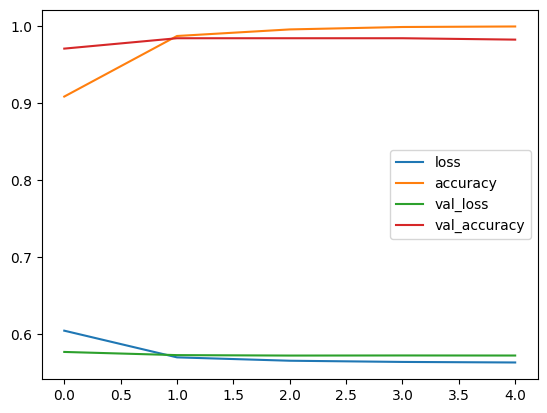

In [59]:
pd.DataFrame(history_1.history).plot()

In [61]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
              X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train
    and test data
    '''
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)))
    return history

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}

    return model_results_dict

In [62]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2)  # compile the model
history_2 = fit_model(model_2, epochs=5)  # fit the model

Epoch 1/5
140/140 [==============================] - 24s 99ms/step - loss: 0.0563 - accuracy: 0.9827 - val_loss: 0.0831 - val_accuracy: 0.9821
Epoch 2/5
140/140 [==============================] - 14s 102ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0961 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 13s 94ms/step - loss: 6.4313e-05 - accuracy: 1.0000 - val_loss: 0.1207 - val_accuracy: 0.9830
Epoch 4/5
140/140 [==============================] - 13s 91ms/step - loss: 2.2819e-05 - accuracy: 1.0000 - val_loss: 0.1274 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 13s 95ms/step - loss: 1.4655e-05 - accuracy: 1.0000 - val_loss: 0.1325 - val_accuracy: 0.9830


In [63]:
import tensorflow_hub as hub

# model with Sequential api
model_3 = keras.Sequential()

# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

compile_model(model_3)

history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 7s 27ms/step - loss: 0.2880 - accuracy: 0.9181 - val_loss: 0.1123 - val_accuracy: 0.9713
Epoch 2/5
140/140 [==============================] - 6s 40ms/step - loss: 0.0786 - accuracy: 0.9805 - val_loss: 0.0695 - val_accuracy: 0.9767
Epoch 3/5
140/140 [==============================] - 3s 24ms/step - loss: 0.0557 - accuracy: 0.9845 - val_loss: 0.0575 - val_accuracy: 0.9830
Epoch 4/5
140/140 [==============================] - 4s 32ms/step - loss: 0.0463 - accuracy: 0.9863 - val_loss: 0.0526 - val_accuracy: 0.9803
Epoch 5/5
140/140 [==============================] - 5s 34ms/step - loss: 0.0393 - accuracy: 0.9886 - val_loss: 0.0511 - val_accuracy: 0.9821


In [64]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()


35/35 [==============================] - 2s 25ms/step


In [65]:
total_results

,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.981166,0.977778,0.880000,0.926316
Bidirectional-LSTM Model,0.982960,0.978102,0.893333,0.933798
USE-Transfer learning Model,0.982063,0.957746,0.906667,0.931507
